In [1]:
import os
import re
import sys
import json
import codecs
import locale
import logging
import requests
from enum import Enum
import datetime as dt
from typing import Union, Optional, Tuple, List, cast

from matplotlib import pyplot as plt    # type: ignore  
import matplotlib.gridspec as gridspec  # type: ignore 
import matplotlib.dates as mdates       # type: ignore


import pandas as pd
import numpy as np


#----------------------------------------------------------------
# Import the procedures that download and transform the pdf file
# into a dataframe.
#----------------------------------------------------------------

module_path = os.path.abspath(os.path.join('..','src'))
common_path = os.path.abspath(os.path.join('..','src','common'))
print("{p2} {p1}".format(p1=common_path, p2=module_path))
if module_path not in sys.path:
    sys.path.append(module_path)
    sys.path.append(common_path)

from common.logger_init     import init_logger    
from common.result_value    import ResultValue, ResultOk, ResultKo    
from common.ChartTools      import set_axes_common_properties 
from common.ChartTools      import remove_tick_lines 
from common.ChartTools      import autolabel 


/Users/ERIZZAG5J/repos/JMeter_report/src /Users/ERIZZAG5J/repos/JMeter_report/src/common


In [2]:
#----------------------------------------------------------------
# Configurations section
#----------------------------------------------------------------

temp_content_dir = os.path.join(os.sep, 'tmp')
images_path = os.path.join("..","images")

now = dt.datetime.now()
sample_date = now.strftime("%d/%m/%Y")

locale.setlocale(locale.LC_ALL, 'it_IT.UTF-8')

ok_statuses = [200, 201, 202]
data_file_path = os.path.join(os.sep,"Users","ERIZZAG5J","Work","jmeter")
data_file_name = "merge_file.jtl"
csv_data_file = os.path.join(data_file_path, data_file_name)

image_file_prefix = "Test-"

class TypeOfOutputChart(Enum):
    PDF = 1
    PNG = 2
    JPG = 3

output_chart_type = TypeOfOutputChart.JPG

In [3]:
dtype_dict: dict = {'asset_id':str}
df = pd.read_csv(csv_data_file,low_memory=False, dtype=dtype_dict
                ,sep='#')  
df["timeStamp"] = pd.to_datetime(df["timeStamp"])
df.set_index("timeStamp", inplace=True)
(df.shape[0],df.dtypes)

(12863728,
 elapsed              int64
 label               object
 responseCode         int64
 responseMessage     object
 threadName          object
 dataType            object
 success               bool
 failureMessage     float64
 bytes                int64
 sentBytes            int64
 grpThreads           int64
 allThreads           int64
 URL                 object
 Filename           float64
 Latency              int64
 SampleCount          int64
 ErrorCount           int64
 Hostname            object
 IdleTime             int64
 Connect              int64
 asset_id            object
 CACHE_HIT          float64
 dtype: object)

In [4]:
# Elenco ordinato di tutti i campioni con tempo di servizio maggiore di 
# un valore dato.
max_elapsed = 300
mask = (df["elapsed"] > max_elapsed) & (df["responseCode"] == 200)
unacceptable_elapsed = df.loc[mask,['asset_id', 'responseCode', 'elapsed','responseCode']]
unacceptable_elapsed.sort_values('elapsed', ascending=False).head(10)

,asset_id,responseCode,elapsed,responseCode
timeStamp,,,,
2022-03-14 11:06:22.033000,311284,200,10403,200
2022-03-14 11:03:57.007300,169800,200,10262,200
2022-03-14 11:06:02.033200,321701,200,10230,200
2022-03-14 11:05:30.037700,378878,200,10221,200
2022-03-14 10:59:07.089900,118987,200,10219,200
2022-03-14 11:05:51.069600,26,200,10212,200
2022-03-14 10:59:09.087400,169785,200,10185,200
2022-03-14 11:03:57.038000,366417,200,10179,200
2022-03-14 11:03:57.033500,910,200,10168,200


In [5]:
# Elenco di tutti i campioni falliti a causa della asserzione sul
# contenuto della risposta.
mask = (df["failureMessage"].str.contains("Expected to find an object") == True)
wrong_response = df.loc[mask,['asset_id', 'elapsed','failureMessage']]
print("Avg: {avg}".format(avg=wrong_response['elapsed'].mean()))
wrong_response.sort_values('elapsed', ascending=False).head(10)

Avg: 1021.2597371659983


,asset_id,elapsed,failureMessage
timeStamp,,,
2022-03-14 11:03:35.032000,279960,30122,Expected to find an object with property ['hls...
2022-03-14 11:02:10.071600,355392,30116,Expected to find an object with property ['hls...
2022-03-14 10:57:57.068100,332558,30108,Expected to find an object with property ['hls...
2022-03-14 11:02:10.072700,1095,30107,Expected to find an object with property ['hls...
2022-03-14 11:02:10.070300,354446,30104,Expected to find an object with property ['hls...
2022-03-14 10:57:57.078400,169526,30104,Expected to find an object with property ['hls...
2022-03-14 11:02:10.070200,354445,30103,Expected to find an object with property ['hls...
2022-03-14 11:02:10.073100,1096,30099,Expected to find an object with property ['hls...
2022-03-14 11:02:10.055600,358959,30098,Expected to find an object with property ['hls...


Time (less than 220): 216852 - (more than 220): 48834
Hit: 0 - Miss: 0


/var/folders/ny/gwc3ss8d6w9bsgvbdll9dw5m0000gq/T/ipykernel_6786/2018343229.py:120: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(x, rotation=80)
/var/folders/ny/gwc3ss8d6w9bsgvbdll9dw5m0000gq/T/ipykernel_6786/2018343229.py:141: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(x, rotation=80)


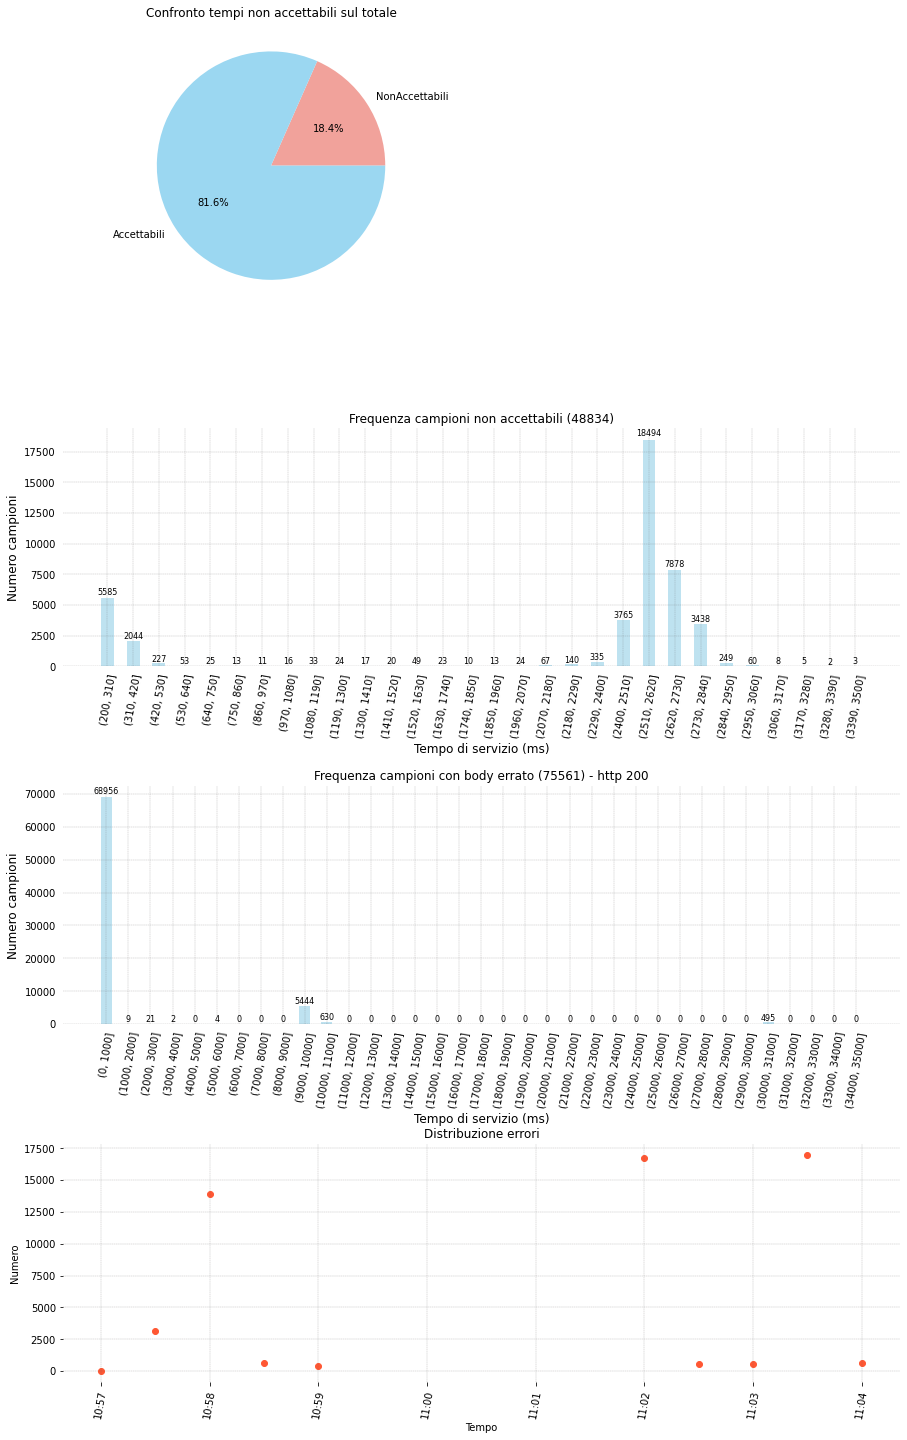

In [6]:
# --------------------------------------------------------------
# Analisi grafica dei valori.
# --------------------------------------------------------------
# CONFIG SECTION
# --------------------------------------------------------------
max_elapsed = 220

# Selezionare qui quali grafici visualizzare.
cache_chart = False
frequency_chart = True
error_frequency_chart = True
error_dist_chart = True

# --------------------------------------------------------------
# DATA SECTION
# --------------------------------------------------------------
# Diagramma a torta dei valori di elapsed maggiori di un valore dato
# ritenuto soddisfacente.
mask = (df["elapsed"] > max_elapsed) & (df["responseCode"] == 200)
unacceptable_elapsed = df.loc[mask,['asset_id', 'elapsed','responseCode']]
unacceptable_elapsed_num = unacceptable_elapsed.shape[0]

mask = (df["responseCode"] == 200)
total_transactions = df.loc[mask,:].shape[0]
acceptable_num = total_transactions - unacceptable_elapsed_num

print("Time (less than {t}): {ok} - (more than {t}): {ko}".format(ok=acceptable_num, ko=unacceptable_elapsed_num,t=max_elapsed))

# --------------------------------------------------------------
# Diagramma a torta relativo al valore cache hit/miss.
mask = (df["CACHE_HIT"] == "Miss") & (df["responseCode"] == 200) & (df['CACHE_HIT'].notnull())
miss_num = df.loc[mask,"CACHE_HIT"].shape[0]
mask = (df["CACHE_HIT"] == "Hit") & (df["responseCode"] == 200) & (df['CACHE_HIT'].notnull())
hit_num = df.loc[mask,"CACHE_HIT"].shape[0]

print("Hit: {hit} - Miss: {miss}".format(hit=hit_num, miss=miss_num))

# --------------------------------------------------------------
mask = (df["elapsed"] > max_elapsed) & (df["responseCode"] == 200)
unacceptable_elapsed = df.loc[mask,['asset_id', 'elapsed','responseCode']]
fr_num = unacceptable_elapsed.shape[0]
cut_bins = list(range(200, 3600, 110))
unacceptable_elapsed['elapsed binned'] = pd.cut(unacceptable_elapsed['elapsed'], bins=cut_bins, right=True)
frequencies = unacceptable_elapsed['elapsed binned'].value_counts(sort=False)
#frequencies = frequencies[frequencies > 0]

# --------------------------------------------------------------
# Analisi della frequenza dei campioni falliti a causa della asserzione.
mask = (df["failureMessage"].str.contains("Expected to find an object") == True)
wrong_response = df.loc[mask,['asset_id', 'elapsed','failureMessage']]
cut_bins = list(range(0, 36000, 1000))
wrong_response['elapsed binned'] = pd.cut(wrong_response['elapsed'], bins=cut_bins, right=True)
wr_frequencies = wrong_response['elapsed binned'].value_counts(sort=False)
wr_num = wrong_response.shape[0]

# --------------------------------------------------------------
# Grafico della serie temporale degli errori dovuti alla asserzione.
time_delta = 30
time_unit = 'S'
td_for_grouper = '{td}{tu}'.format(td=str(time_delta), tu=time_unit)
wr_binned_elapsed = wrong_response.groupby(pd.Grouper(level='timeStamp', freq=td_for_grouper))['elapsed'].agg(['count'])

mask = (wr_binned_elapsed['count'].notnull()) & (wr_binned_elapsed['count'] > 0)
errors_ts = wr_binned_elapsed.loc[mask,:].head(10)

# --------------------------------------------------------------
# CHART SECTION
# --------------------------------------------------------------
fig = plt.figure(figsize=(15, 25))
gs1 = gridspec.GridSpec(4, 2
                       ,figure=fig 
                       ,hspace=0.48
                       ,wspace=0.01
                       ,height_ratios=[12, 10, 10, 10]
                       ,width_ratios=[10, 10])
ax = []
idx = 0
ax.append(fig.add_subplot(gs1[0,0]))

labels = ["NonAccettabili", "Accettabili"]

acceptable_color = "#f1a29b"
unacceptable_color = "#9bd7f1"
chart_unacc_acc = [unacceptable_elapsed_num, acceptable_num]

ax[idx].pie(chart_unacc_acc, labels=labels, colors=[acceptable_color, unacceptable_color], autopct='%1.1f%%')
ax[idx].set_title("Confronto tempi non accettabili sul totale", fontsize=12)

if cache_chart == True:
    idx += 1
    ax.append(fig.add_subplot(gs1[0,1]))

    labels = ["Hit", "Miss"]
    chart_hit_miss = [hit_num, miss_num]
    hit_color = "#9bd7f1"
    miss_color = "#f1a29b"

    ax[idx].pie(chart_hit_miss, labels=labels, colors=[hit_color, miss_color], autopct='%1.1f%%')
    ax[idx].set_title("Hit / Miss", fontsize=12)

if frequency_chart == True:
    idx += 1
    ax.append(fig.add_subplot(gs1[1,:]))

    y = frequencies
    x = frequencies.index.astype(str)
    set_axes_common_properties(ax[idx], no_grid=False)
    
    ax[idx].set_title("Frequenza campioni non accettabili ({n})".format(n=fr_num), fontsize=12)
    ax[idx].set_ylabel("Numero campioni", fontsize=12)
    ax[idx].set_xlabel("Tempo di servizio (ms)", fontsize=12)
        
    width = 0.5
    colors = ["#BEE2F0", "#d5d5d5", "#c87607"]
    rects = ax[idx].bar(x, y, width=width, color=colors[0], label="elapsed-frequency label")
    
    remove_tick_lines('y', ax[idx])
    remove_tick_lines('x', ax[idx])
    autolabel(rects, ax[idx], 1)
    ax[idx].set_xticklabels(x, rotation=80)

if error_frequency_chart == True:
    idx += 1
    ax.append(fig.add_subplot(gs1[2,:]))
    
    y = wr_frequencies
    x = wr_frequencies.index.astype(str)
    set_axes_common_properties(ax[idx], no_grid=False)
    
    ax[idx].set_title("Frequenza campioni con body errato ({n}) - http 200".format(n=wr_num), fontsize=12)
    ax[idx].set_ylabel("Numero campioni", fontsize=12)
    ax[idx].set_xlabel("Tempo di servizio (ms)", fontsize=12)
        
    width = 0.5
    colors = ["#BEE2F0", "#d5d5d5", "#c87607"]
    rects = ax[idx].bar(x, y, width=width, color=colors[0], label="elapsed-frequency label")
    
    remove_tick_lines('y', ax[idx])
    remove_tick_lines('x', ax[idx])
    autolabel(rects, ax[idx], 1)    
    ax[idx].set_xticklabels(x, rotation=80)

if error_dist_chart == True:
    idx += 1
    ax.append(fig.add_subplot(gs1[3,:]))

    minutes = mdates.MinuteLocator(interval = 1)
    minutes_fmt = mdates.DateFormatter('%H:%M')

    set_axes_common_properties(ax[idx], no_grid=False)
    ax[idx].xaxis.set_major_locator(minutes)
    ax[idx].xaxis.set_major_formatter(minutes_fmt)
    
    ax[idx].set_title("Distribuzione errori", fontsize=12)
    ax[idx].set_ylabel("Numero", fontsize=10)
    ax[idx].set_xlabel("Tempo", fontsize=10)
    
    x = errors_ts.index
    y = errors_ts['count']
    set_axes_common_properties(ax[idx], no_grid=False)
    
    ax[idx].scatter(x, y, color="#FF5733")
    ax[idx].tick_params(axis='x', labelrotation=80)


        

In [4]:
df["threadName"].unique()

array(['node-01 setUp Thread Group 1-1', 'node-01 Auth token 1-1',
       'node-01 Listing 2-1', 'node-01 Listing 2-2',
       'node-01 Listing 2-3', 'node-01 Listing 2-4',
       'node-01 Listing 2-5', 'node-01 Listing 2-6',
       'node-01 Listing 2-7', 'node-01 Listing 2-8',
       'node-01 Listing 2-9', 'node-01 Listing 2-10',
       'node-01 Listing 2-11', 'node-01 Listing 2-12',
       'node-01 Listing 2-13', 'node-01 Listing 2-14',
       'node-01 Listing 2-15', 'node-01 Listing 2-16',
       'node-01 Listing 2-17', 'node-01 Listing 2-18',
       'node-01 Listing 2-19', 'node-01 Listing 2-20',
       'node-01 tearDown Thread Group 1-1',
       'node-02 setUp Thread Group 1-1', 'node-02 Auth token 1-1',
       'node-02 Listing 2-1', 'node-02 Listing 2-2',
       'node-02 Listing 2-3', 'node-02 Listing 2-4',
       'node-02 Listing 2-5', 'node-02 Listing 2-6',
       'node-02 Listing 2-7', 'node-02 Listing 2-8',
       'node-02 Listing 2-9', 'node-02 Listing 2-10',
       'node-02

In [5]:
df.loc[:,["threadName","grpThreads","allThreads"]]

,threadName,grpThreads,allThreads
0,node-02 setUp Thread Group 1-1,1,1
1,node-02 setUp Thread Group 1-1,1,1
2,node-02 Auth token 1-1,1,1
3,node-02 Auth token 1-1,1,1
4,node-02 Playback 2-1,1,2
...,...,...,...
8567069,node-03 Playback 2-18,4,4
8567070,node-03 Playback 2-24,3,3
8567071,node-03 Playback 2-20,2,2
8567072,node-03 Playback 2-25,1,1


In [9]:
df.loc[:,"threadName"].unique()

array(['node-01 Manifest 1-1', 'node-01 Manifest 1-2',
       'node-01 Manifest 1-3', 'node-01 Manifest 1-4',
       'node-01 Manifest 1-5', 'node-01 Manifest 1-6',
       'node-01 Manifest 1-7', 'node-01 Manifest 1-8',
       'node-01 Manifest 1-9', 'node-01 Manifest 1-10',
       'node-01 Manifest 1-11', 'node-01 Manifest 1-12',
       'node-01 Manifest 1-13', 'node-01 Manifest 1-14',
       'node-01 Manifest 1-15', 'node-01 Manifest 1-16',
       'node-01 Manifest 1-17', 'node-01 Manifest 1-18',
       'node-01 Manifest 1-19', 'node-01 Manifest 1-20',
       'node-01 Manifest 1-21', 'node-01 Manifest 1-22',
       'node-01 Manifest 1-23', 'node-01 Manifest 1-24',
       'node-01 Manifest 1-25', 'node-01 Manifest 1-26',
       'node-01 Manifest 1-27', 'node-01 Manifest 1-28',
       'node-01 Manifest 1-29', 'node-01 Manifest 1-30',
       'node-01 Manifest 1-31', 'node-01 Manifest 1-32',
       'node-01 Manifest 1-33', 'node-01 Manifest 1-34',
       'node-01 Manifest 1-35', 'node-01